In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt
from statistics import NormalDist
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [78]:
class BlackScholes:
    @staticmethod
    def black_scholes_call(spot, strike, time_to_expiry, volatility):
        d1 = (np.log(spot) - np.log(strike) + (0.5 * volatility * volatility) * time_to_expiry) / (
            volatility * np.sqrt(time_to_expiry)
        )
        d2 = d1 - volatility * np.sqrt(time_to_expiry)
        call_price = spot * NormalDist().cdf(d1) - strike * NormalDist().cdf(d2)
        return call_price

    @staticmethod
    def black_scholes_put(spot, strike, time_to_expiry, volatility):
        d1 = (np.log(spot / strike) + (0.5 * volatility * volatility) * time_to_expiry) / (
            volatility * np.sqrt(time_to_expiry)
        )
        d2 = d1 - volatility * np.sqrt(time_to_expiry)
        put_price = strike * NormalDist().cdf(-d2) - spot * NormalDist().cdf(-d1)
        return put_price

    @staticmethod
    def delta(spot, strike, time_to_expiry, volatility):
        d1 = (
            np.log(spot) - np.log(strike) + (0.5 * volatility * volatility) * time_to_expiry
        ) / (volatility * np.sqrt(time_to_expiry))
        return NormalDist().cdf(d1)

    @staticmethod
    def gamma(spot, strike, time_to_expiry, volatility):
        d1 = (
            np.log(spot) - np.log(strike) + (0.5 * volatility * volatility) * time_to_expiry
        ) / (volatility * np.sqrt(time_to_expiry))
        return NormalDist().pdf(d1) / (spot * volatility * np.sqrt(time_to_expiry))

    @staticmethod
    def vega(spot, strike, time_to_expiry, volatility):
        d1 = (
            np.log(spot) - np.log(strike) + (0.5 * volatility * volatility) * time_to_expiry
        ) / (volatility * np.sqrt(time_to_expiry))
        # print(f"d1: {d1}")
        # print(f"vol: {volatility}")
        # print(f"spot: {spot}")
        # print(f"strike: {strike}")
        # print(f"time: {time_to_expiry}")
        return NormalDist().pdf(d1) * (spot * np.sqrt(time_to_expiry)) / 100

    @staticmethod
    def implied_volatility(
        call_price, spot, strike, time_to_expiry, max_iterations=200, tolerance=1e-10
    ):
        low_vol = 0.01
        high_vol = 1.0
        volatility = (low_vol + high_vol) / 2.0  # Initial guess as the midpoint
        for _ in range(max_iterations):
            estimated_price = BlackScholes.black_scholes_call(
                spot, strike, time_to_expiry, volatility
            )
            diff = estimated_price - call_price
            if abs(diff) < tolerance:
                break
            elif diff > 0:
                high_vol = volatility
            else:
                low_vol = volatility
            volatility = (low_vol + high_vol) / 2.0
        return volatility

In [32]:
all_dfs = []
for day in range(3):
    file = f"prices_round_3_day_{day}.csv"
    df_day = pd.read_csv(Path(file), sep=';')
    df_day['timestamp'] += int(day * 1e6)
    all_dfs.append(df_day)

df = pd.concat(all_dfs, ignore_index=True)



In [73]:

# Compute mid-price for VOLCANIC_ROCK
rock_df = df[df['product'] == 'VOLCANIC_ROCK'].copy()
rock_df["mid_price"] = (rock_df["bid_price_1"] + rock_df["ask_price_1"]) / 2
rock_df = rock_df[["timestamp", "mid_price"]].dropna().set_index("timestamp")

# === Voucher settings ===
voucher_strikes = [9500, 9750, 10000, 10250, 10500]
voucher_products = [f"VOLCANIC_ROCK_VOUCHER_{strike}" for strike in voucher_strikes]

# === Process each voucher ===
points = []

for strike, product in zip(voucher_strikes, voucher_products):
    voucher_df = df[df["product"] == product].copy()
    if voucher_df.empty:
        continue
    voucher_df["mid_price"] = (voucher_df["bid_price_1"] + voucher_df["ask_price_1"]) / 2
    voucher_df = voucher_df.dropna(subset=["mid_price"])

    for _, row in voucher_df.iterrows():
        ts = row["timestamp"]
        if ts not in rock_df.index:
            continue
        spot_price = rock_df.loc[ts, "mid_price"]
        option_price = row["mid_price"]
        day = row["day"]
        T = float(((8)/8) - ((float(ts)/1000000)/8)) # Time to expiry in days -> scaled

        try:
            iv = BlackScholes.implied_volatility(option_price, spot_price, strike, T)
            if iv < 0.02:
                continue
            moneyness = log(strike / spot_price) / sqrt(T)
            mt = moneyness
            a=1.59195
            b=0.00258
            c=0.02210
            iv2 = mt*mt*a + b*mt + c
            if not np.isnan(iv):
                points.append({"strike": strike, "moneyness": moneyness, "iv": iv, "iv2": iv2, "timestamp": ts, "op_price": option_price, "spot": spot_price, "T": T})
        except:
            continue


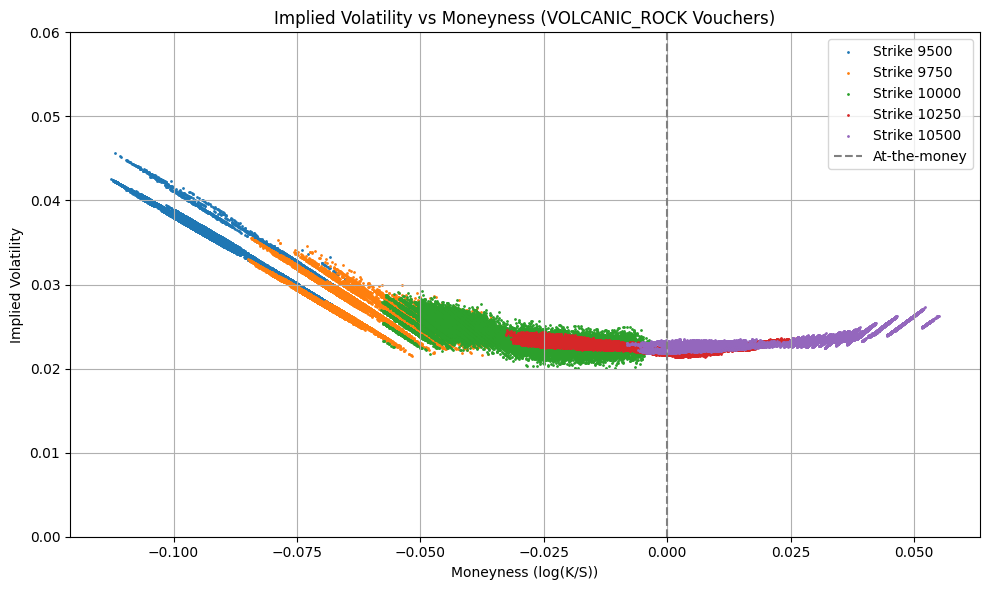

In [74]:
points_df = pd.DataFrame(points)

plt.figure(figsize=(10, 6))
for strike in voucher_strikes:
    subset = points_df[points_df["strike"] == strike]
    plt.scatter(subset["moneyness"], subset["iv"], s=1, label=f"Strike {strike}")

plt.axvline(0, color='gray', linestyle='--', label='At-the-money')
plt.xlabel("Moneyness (log(K/S))")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility vs Moneyness (VOLCANIC_ROCK Vouchers)")
plt.ylim(0.00, 0.06)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


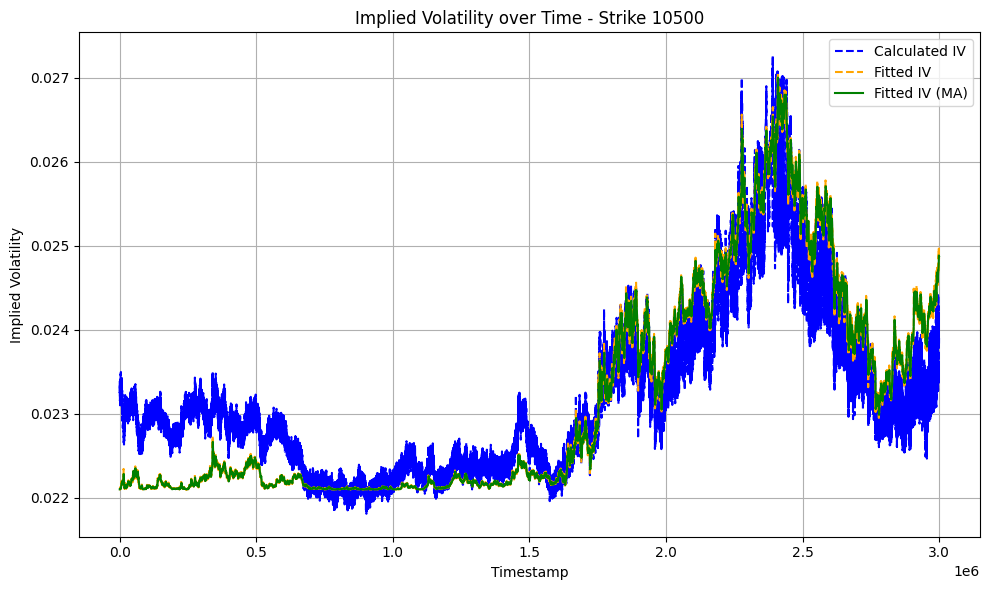

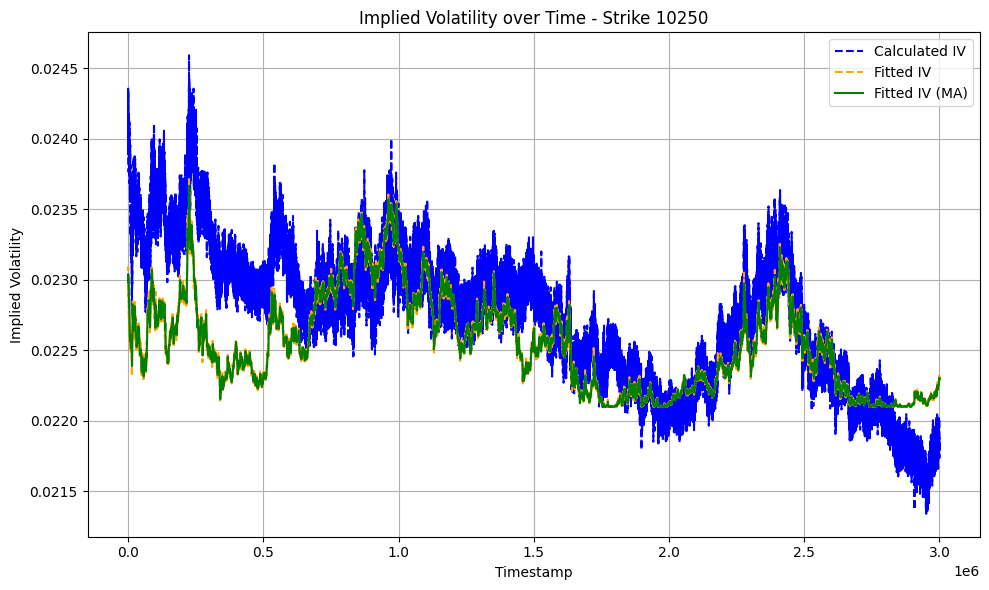

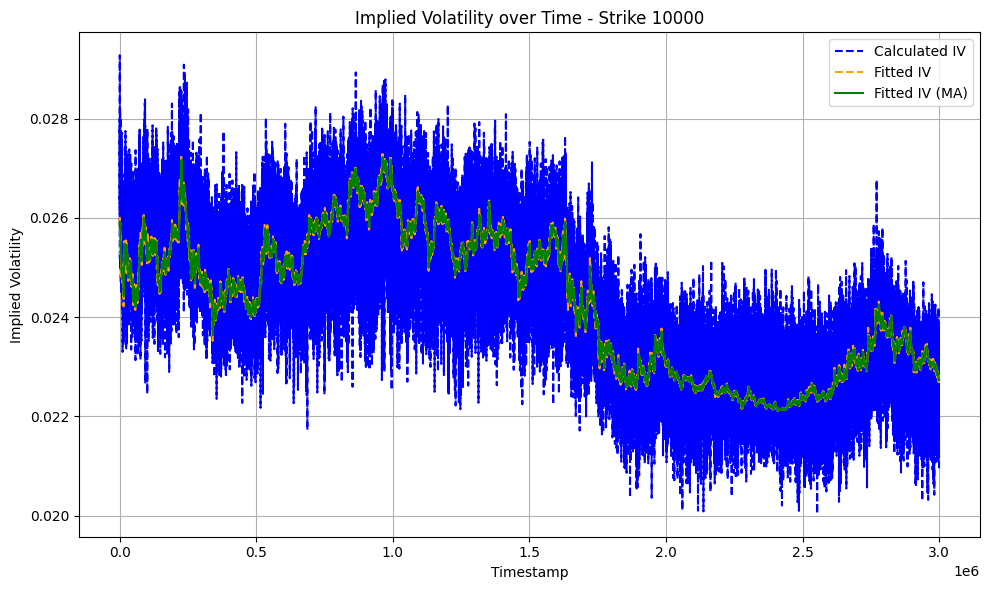

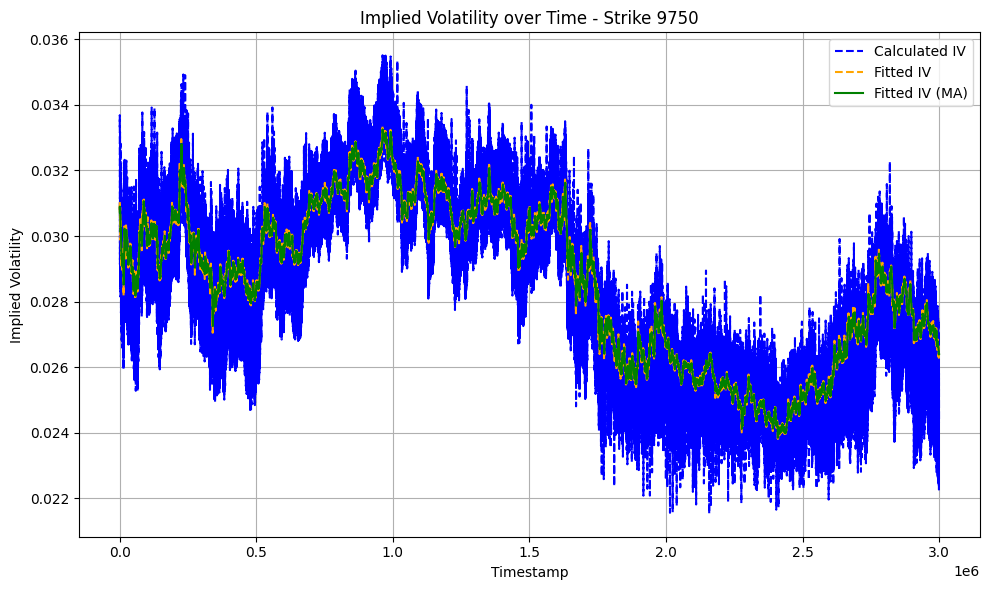

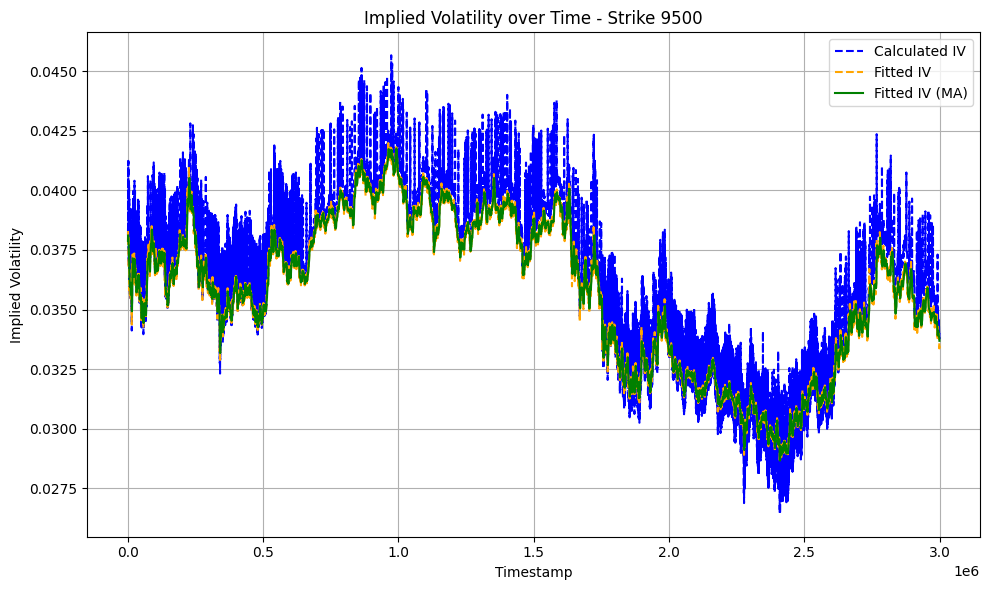

In [77]:

# Loop over each unique strike
for strike in set(points_df['strike']):
    points_df2 = points_df[points_df['strike'] == strike].sort_values("timestamp")
    
    # Calculate moving average of the fitted IV (iv2)
    points_df2['iv2_ma'] = points_df2['iv2'].rolling(window=10, min_periods=1).mean()
    
    plt.figure(figsize=(10, 6))  # Create a new figure

    plt.plot(points_df2["timestamp"], points_df2['iv'], label='Calculated IV', color='blue', linestyle='dashed')
    plt.plot(points_df2["timestamp"], points_df2['iv2'], label='Fitted IV', color='orange', linestyle='dashed')
    plt.plot(points_df2["timestamp"], points_df2['iv2_ma'], label='Fitted IV (MA)', color='green', linestyle='solid')

    plt.title(f"Implied Volatility over Time - Strike {strike}")
    plt.xlabel("Timestamp")
    plt.ylabel("Implied Volatility")
    # plt.ylim(0, 0.04)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

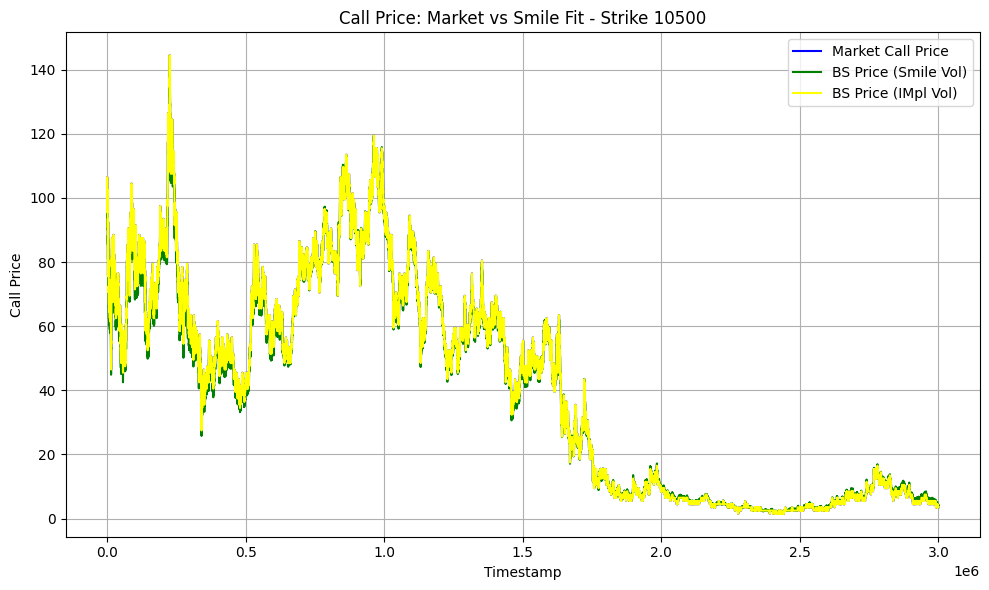

1.2917895943187947
5.404919887002682e-11


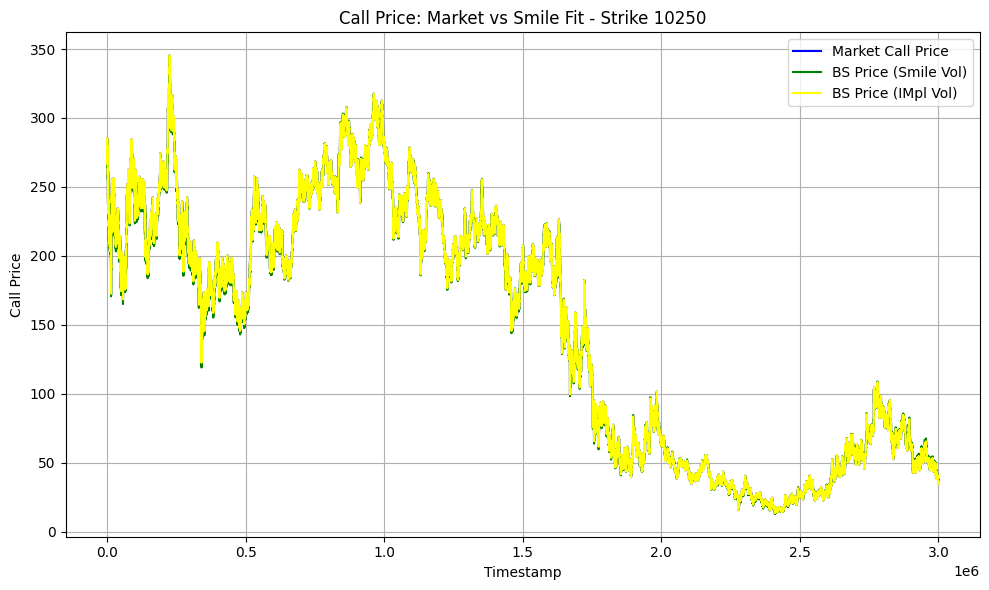

1.0305204803897232
5.2217343992460804e-11


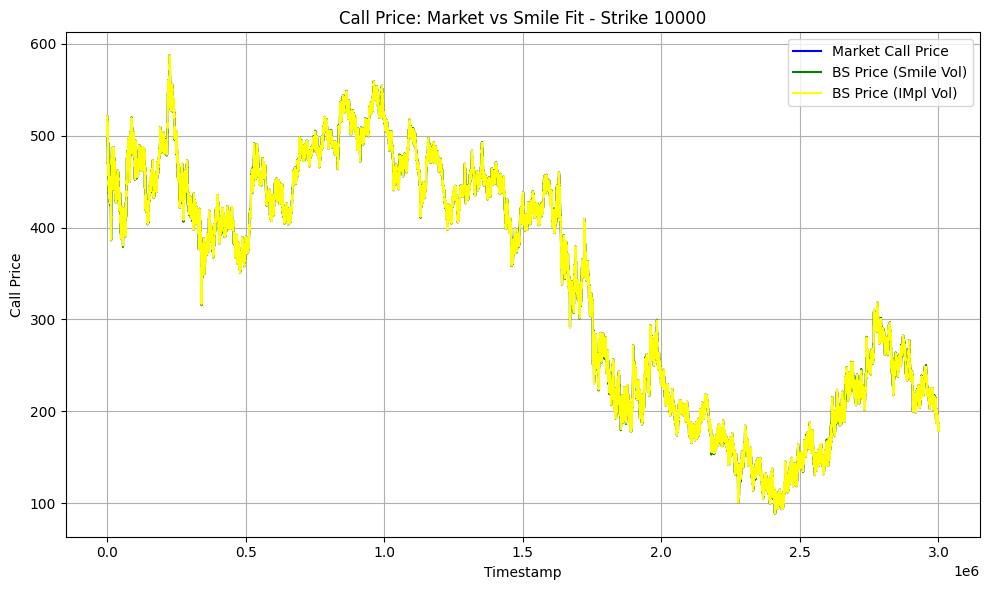

1.3048876404884933
5.2082642037567916e-11


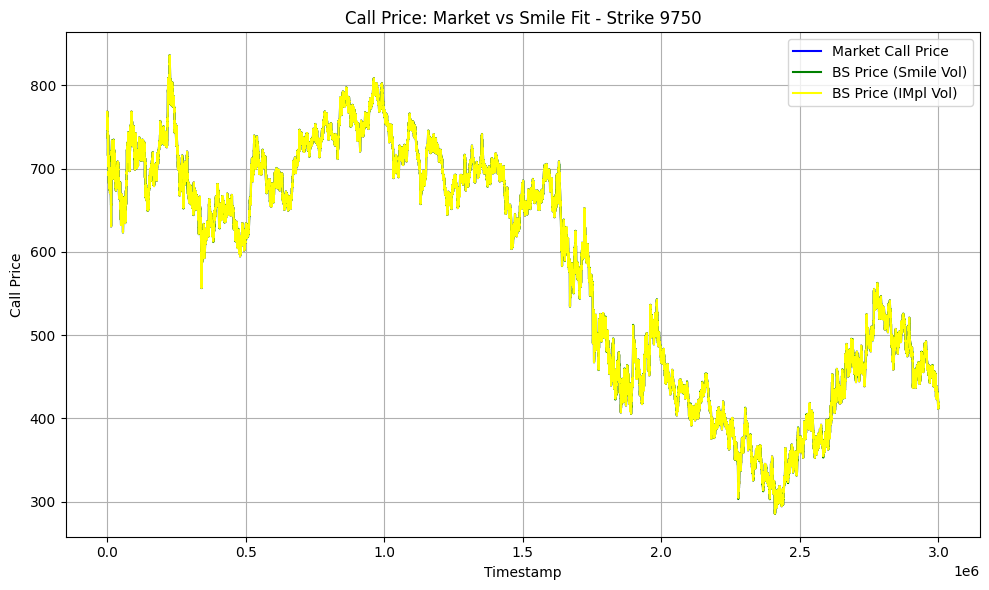

0.4177240685419481
5.1973848592000034e-11


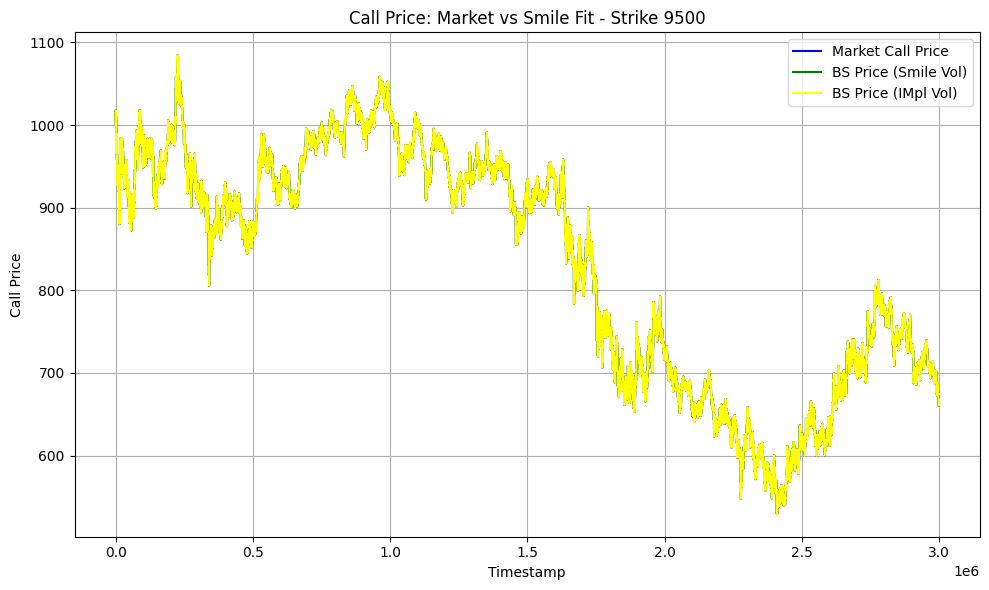

0.15935927593414811
5.373969595833971e-11


In [83]:


# Smile coefficients
a = 1.59195
b = 0.00258
c = 0.02210

# Plotting for each strike
for strike in set(points_df['strike']):
    points_df2 = points_df[points_df['strike'] == strike].sort_values("timestamp").copy()
    
    # Compute smile volatility and corresponding call prices
    points_df2['smile_vol'] = a * points_df2['moneyness']**2 + b * points_df2['moneyness'] + c
    points_df2['bs_price_smile_vol'] = points_df2.apply(
        lambda row: BlackScholes.black_scholes_call(row['spot'], row['strike'], row['T'], row['smile_vol']), axis=1
    )
    points_df2['impl_price'] = points_df2.apply(
        lambda row: BlackScholes.black_scholes_call(row['spot'], row['strike'], row['T'], row['iv']), axis=1
    )

    std_diff = np.std(points_df2['op_price'] - points_df2['bs_price_smile_vol'])
    std_diff2 = np.std(points_df2['op_price'] - points_df2['impl_price'])

    # Plot market vs smile-fitted BS prices
    plt.figure(figsize=(10, 6))
    plt.plot(points_df2['timestamp'], points_df2['op_price'], label='Market Call Price', color='blue')
    plt.plot(points_df2['timestamp'], points_df2['bs_price_smile_vol'], label='BS Price (Smile Vol)', color='green')
    plt.plot(points_df2['timestamp'], points_df2['impl_price'], label='BS Price (IMpl Vol)', color='yellow')
    
    plt.title(f"Call Price: Market vs Smile Fit - Strike {strike}")
    plt.xlabel("Timestamp")
    plt.ylabel("Call Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(std_diff)
    print(std_diff2)